## **Цели и задачи исследования**
***
**Цель исследования** - *построить DL модель, которая бы предсказывала стоимость автомобиля по его характеристикам.*

*Целью исследования определяются следующие* **задачи:**

* *построить "наивную" модель, предсказывающую цену автомобиля;*
* *провести разведавательный анализ данных, обработать выбросы, избавиться от мульколлинеарности, предсказать цену автомобиля, используя алгоритм CatBoost*;
* *построить простую нейронную;*
* *добавить к простой нейронной сети текстовые данные, заранее их обработав;*
* *добавить к нейронной сети с текстовыми данными изображения.*


<img src="https://www.avtovzglyad.ru/media/article/car_sales.jpg.740x555_q85_box-109%2C0%2C915%2C603_crop_detail_upscale.jpg"/>

### 1. Импортирование библиотек

In [1]:
# импортируем библиотеку для работы с текстом
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.0 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 7.3 MB/s eta 0:00:01     |█████▌                          | 1.4 MB 7.3 MB/s eta 0:00:01     |███████████████████████████████▉| 8.2 MB 7.3 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# библиотеки для работы с dataset
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import os
import sys
import PIL
import cv2
import re
import random

# опции для вывода данных в нужном количестве и формате
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# системная библиотека
import sys

# библиотеки для ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

# библиотеки для парсинга сайта
import requests, json

# библиотеки для визуализации
import altair as alt
# отключение ограничения в 5000 строк для alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

# библиотеки для статистического анализа
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import chi2

!pip install -q tensorflow==2.3

# аугментации изображений
!pip install albumentations -q

# библиотеки для построения модели
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import albumentations

# библиотеки для лемматизации текста
import spacy
from spacy.lang.ru import Russian
import sys
import pymorphy2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# очистка модели от предыдущих сессий
tf.keras.backend.clear_session()

### 2. Обеспечение воспроизводимости экспериментов

In [4]:
# Определяем версии Python, библиотеки Numpy и Tensorflow
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
# фиксация random_seed для воспроивзодимости экспериментов
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
# фиксация версий пакетов, для воспроизводимсти экспериментов
!pip freeze > requirements.txt

### 3. Определение метрики качества модели

*MAPE(Mean Percentage Absolute Error)- средняя абсолютная ошибка в процентах.*

$$MAPE={1\over{n}}+{\sum{|y-\bar{Y}|\over\bar{Y}}}$$

*где:*
* y  - *фактическое значение за анализируемый период;*
* Y - *значение прогнозной модели за анализируемый период;*
* n - *количество периодов.*

In [7]:
# функция для расчета средней абсолютной ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### 4. Переменные

In [8]:
VERSION = 16
VAL_SIZE = 0.20

### 5. Функции, используемые для обработки данных

In [9]:
def description_column(x):
    
    """Функция используется для описания 
     столбца текстового типа """
    
    print('Количество уникальных значений в столбце:',x.nunique())
    print('Перечень уникальных значений:', x.unique())
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print("Количество значений, встретившихся в столбце более 10 раз:", (x.value_counts()>10).sum())

def description_column_count(x):
    
    """Функция используется для описания 
     столбца числового типа """
    
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print('Минимальное значение:', x.min())
    print('Максимальное значение:',x.max())  
    
def outliers(x): 
    
    """Функция используется для 
    определения границ выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    print('25-й квартиль: {},'.format(q25), '75-й квартиль: {},'.format(q75), 'IQR: {},'.format(IQR),
     "границы выбросов: [{x_min},{x_max}].".format(x_min = q25-1.5*IQR, x_max = q75+1.5*IQR))

def delete_outliers(x): 
    
    """Функция используется для 
    очистки данных от выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    x_min =q25-1.5*IQR
    x_max =q75+1.5*IQR
    return x_min, x_max
    
def boxplot(x1,y1,d,t,tx,ty):
    
    """Функция используется для 
    вывода boxplot по нескольким признакам"""
    
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    sns.boxplot(x=x1, y=y1, data=d, linewidth=1, flierprops=red_square)
    plt.title(t, fontsize=15, color='black')
    plt.xlabel(tx, fontsize=15, color='black')
    plt.ylabel(ty, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    

def one_boxplot(x, title, x_title):
    
    """Функция используется для 
    вывода boxplot по одному признаку"""
    
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.boxplot(x, linewidth=1, flierprops=red_square)
    ax.set_title(title, fontsize=15, color='black')
    ax.set_xlabel(x_title, fontsize=15, color='black')

def correlation(x,y):
    
    """Функция используется для 
    расчета коэффициента корреляции""" 
        
    display(pd.DataFrame(all_data[[x,y]].corr()))

def get_stat_dif(column):
    cols = all_data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(all_data.loc[all_data.loc[:, column] == comb[0], 'score'], 
                        all_data.loc[all_data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

def cm_to_inch(value):
    return value/2.54

def bar_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.pivot_table(values = [x, z], index = [y], aggfunc = c).plot(kind = 'area', title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.title(t, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='lower right', facecolor='black', fontsize=15)
    plt.legend()
    plt.grid(False)
    plt.show()

def area_two_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.pivot_table(values = [x], index = [y], columns=[z], aggfunc = c).plot(kind = 'area',stacked=True,title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.legend()
    plt.grid(False)
    plt.show()
    
def share(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по долям"""
    
    new=pd.DataFrame(x.value_counts(normalize = True)*100).reset_index(level=0).head(10)
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)   
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='left', size=16)


def share_count(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по долям"""
    
    new=pd.DataFrame(x.value_counts()).reset_index(level=0).head(10).sort_values(by=['index'])
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='center', size=16)

def bar_groupby(x,y,z,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по нескольким признакам"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.groupby(by=[x,y])[z].value_counts(normalize=True).plot(kind='bar', title=t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    plt.show()

def hist_(x):
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    plt.hist(x)
    
def correlation_vis(x_name, y_name, title):
    
    """Функция используется для 
    вывода графика распределения"""
    
    plt.style.use('seaborn')
    ax = sns.jointplot(x=x_name, y=y_name, data=df_corr, kind='scatter')

def altair_bar(data, x_name, y_name, legend_name, title_name):
    
    bar = alt.Chart(data,title=title_name).mark_bar(size=100).encode(
    x=alt.X(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13, labelAngle=360)),
    y=alt.Y(y_name, axis=alt.Axis(title=y_name, labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13)
    )
    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dy=-5).encode(
    text=alt.Text(y_name, format="s"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=840)

def altair_bar_share(data, x_name, y_name, title_name, sort):
    
    new=pd.DataFrame(data.value_counts(normalize = True)).reset_index(level=0).head(10).sort_values(by=sort, 
                                                                                                    ascending=False)
    new.columns=([x_name, y_name])
    bar = alt.Chart(new, title=title_name).mark_bar(orient='horizontal').encode(
    y=alt.Y(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13)),
    x=alt.X(y_name, axis=alt.Axis(title=y_name, format='%', labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13)
    )

    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dx=40).encode(
    text=alt.Text(y_name, format="p"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=820)

def hist(data, x1, x2, ylabel, xlabel, title):
    bins = np.arange(0, x1, x2)
    plt.style.use('seaborn')
    _, ax = plt.subplots(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax.hist(data, bins = bins)
    ax.set_ylabel(ylabel, fontsize=15, color='black')
    ax.set_xlabel(xlabel, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')

### 6 Первичный анализ, создание "наивной" модели

*Посмотрим на типы признаков данных в dataset*:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [13]:
train.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый


In [14]:
# уберем 'description', 'sell_id'
train=train[['bodyType','brand', 'color','engineDisplacement','enginePower','fuelType','mileage','modelDate','model_info',
          'name','numberOfDoors','price','productionDate','vehicleConfiguration','vehicleTransmission',
           'Владельцы','Владение','ПТС','Привод','Руль']]
train.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый



**Комментарий:** перед построением рабочей модели важно создать простую, **"наивную" модель**, которая будет предсказывать среднюю цену по модели машины и году ее выпуска. На метрику наивной модели можно ориентироваться для понимания направления движения - мы идем в сторону ухудшения решения или его улучшения.




In [15]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [16]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


**Вывод:** точность простой модели составила 19,88%. Наша задача - улучшить результат.

### 7. Разведовательный анализ данных

**Этапы анализа:** 
* Определить количество нулевых значений, уникальных значений;
* Построить диаграмму распределения признака;
* Принять решение по обработке нулевых значений. Варианты решения:
    1. заполнить, опираясь на данные из других столбцов;
    2. удалить нулевые значения;
    3. проставить среднее значение (для числовые столбцов);
    4. проставить рандомный признак (для текстовых столбцов);
    5. ничего не делать.
* Выявить выбросы и провести их обработку.

In [17]:
# исключим из анализа столбец description, sell_id
test=test[['bodyType','brand', 'color','engineDisplacement','enginePower','fuelType','mileage','modelDate','model_info',
           'name','numberOfDoors','productionDate','vehicleConfiguration','vehicleTransmission',
           'Владельцы','Владение','ПТС','Привод','Руль']]
test.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый


**Комментарий:** для дальнейшей обработки объединим тестовый и тренировочный dataframe

In [18]:
train['sample'] = 'train' 
test['sample'] = 'test'
# фиктивный столбец с ценой
test['price'] = 0 

# объединяем 
data = test.append(train, sort=False).reset_index(drop=True)
print(train.shape, test.shape, data.shape)

# удалим дубликаты
data = data.drop_duplicates()

(6682, 21) (1671, 21) (8353, 21)


In [19]:
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,test,0.0
1,купе,BMW,белый,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,test,0.0


### 7.1 BodyType

In [20]:
description_column(data['bodyType'])

Количество уникальных значений в столбце: 17
Перечень уникальных значений: ['универсал 5 дв.' 'купе' 'седан' 'внедорожник 5 дв.' 'родстер' 'лифтбек'
 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе-хардтоп' 'внедорожник 3 дв.'
 'минивэн' 'кабриолет' 'пикап двойная кабина' 'внедорожник открытый'
 'компактвэн' 'седан 2 дв.' 'лимузин']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 11


In [21]:
# замена на строчные буквы
data['bodyType'] = data['bodyType'].apply(lambda x: x.lower())

In [22]:
print('Количество строк, где есть нули:', len(data[data['bodyType']==0]))

Количество строк, где есть нули: 0


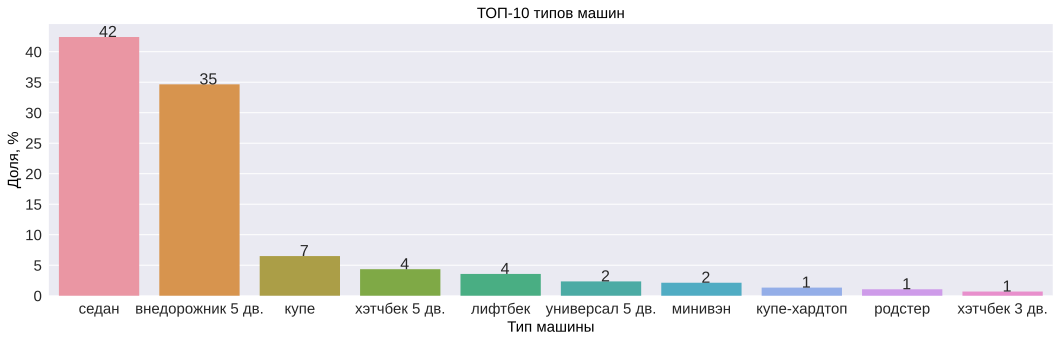

In [23]:
share(data['bodyType'], 'Тип машины', 'Доля, %', 'ТОП-10 типов машин')

In [24]:
# категориальные переменные в число
for colum in ['bodyType']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.2 Brand

In [25]:
description_column(data['brand'])

Количество уникальных значений в столбце: 3
Перечень уникальных значений: ['MERCEDES' 'BMW' 'AUDI']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 3


In [26]:
# замена на строчные буквы
data['brand'] = data['brand'].apply(lambda x: x.lower())

In [27]:
print('Количество строк, где есть нули:', len(data[data['brand']==0]))

Количество строк, где есть нули: 0


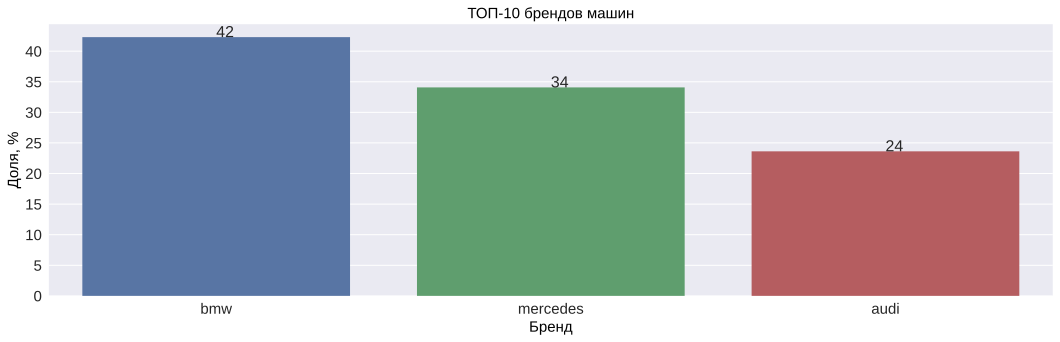

In [28]:
share(data['brand'], 'Бренд', 'Доля, %', 'ТОП-10 брендов машин')

In [29]:
# категориальные переменные в число
for colum in ['brand']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.3 Color

In [30]:
description_column(data['color'])

Количество уникальных значений в столбце: 16
Перечень уникальных значений: ['чёрный' 'белый' 'пурпурный' 'синий' 'коричневый' 'серый' 'зелёный'
 'серебристый' 'красный' 'оранжевый' 'голубой' 'фиолетовый' 'бежевый'
 'жёлтый' 'золотистый' 'розовый']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 15


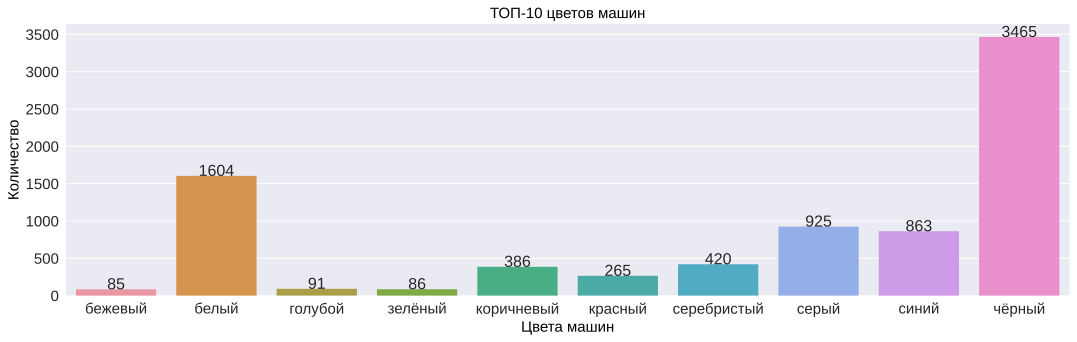

In [31]:
share_count(data['color'], 'Цвета машин', 'Количество', 'ТОП-10 цветов машин')

In [32]:
print('Количество строк, где есть нули:', len(data[data['color']==0]))

Количество строк, где есть нули: 0


In [33]:
# категориальные переменные в число
for colum in ['color']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['color'] = data['color'].astype(int)

### 7.4 EngineDisplacement

In [34]:
description_column(data['engineDisplacement'])

Количество уникальных значений в столбце: 48
Перечень уникальных значений: ['3.0 LTR' '2.5 LTR' '2.0 LTR' '3.5 LTR' '1.8 LTR' '2.2 LTR' '5.5 LTR'
 '4.8 LTR' '1.6 LTR' '4.7 LTR' '4.0 LTR' '1.5 LTR' '2.4 LTR' '1.4 LTR'
 '2.1 LTR' '5.2 LTR' '4.4 LTR' '2.8 LTR' '4.2 LTR' '3.2 LTR' '6.0 LTR'
 '3.7 LTR' '5.0 LTR' '1.2 LTR' '3.6 LTR' '2.3 LTR' '6.2 LTR' '1.7 LTR'
 '1.3 LTR' '5.4 LTR' '3.1 LTR' '2.6 LTR' '3.8 LTR' '4.1 LTR' '2.9 LTR'
 '6.6 LTR' '5.9 LTR' 'undefined LTR' '2.7 LTR' '0.7 LTR' '1.9 LTR'
 '4.3 LTR' '5.8 LTR' '4.9 LTR' '3.4 LTR' '6.3 LTR' '5.6 LTR' '4.6 LTR']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 35


In [35]:
print('Количество строк, где есть нули:', len(data[data['engineDisplacement']==0]))

Количество строк, где есть нули: 0


In [36]:
# категориальные переменные в число
for colum in ['engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.5 EnginePower

In [37]:
description_column(data['enginePower'])

Количество уникальных значений в столбце: 154
Перечень уникальных значений: ['220 N12' '313 N12' '218 N12' '136 N12' '190 N12' '340 N12' '245 N12'
 '316 N12' '170 N12' '160 N12' '231 N12' '388 N12' '180 N12' '367 N12'
 '115 N12' '184 N12' '177 N12' '455 N12' '422 N12' '163 N12' '249 N12'
 '272 N12' '224 N12' '122 N12' '557 N12' '333 N12' '306 N12' '156 N12'
 '150 N12' '264 N12' '450 N12' '555 N12' '407 N12' '130 N12' '400 N12'
 '204 N12' '469 N12' '192 N12' '210 N12' '211 N12' '239 N12' '200 N12'
 '350 N12' '420 N12' '300 N12' '381 N12' '265 N12' '258 N12' '390 N12'
 '197 N12' '120 N12' '544 N12' '193 N12' '235 N12' '233 N12' '394 N12'
 '355 N12' '421 N12' '320 N12' '585 N12' '105 N12' '280 N12' '194 N12'
 '132 N12' '639 N12' '250 N12' '335 N12' '510 N12' '116 N12' '360 N12'
 '238 N12' '225 N12' '625 N12' '571 N12' '507 N12' '286 N12' '372 N12'
 '575 N12' '408 N12' '310 N12' '354 N12' '255 N12' '435 N12' '525 N12'
 '591 N12' '109 N12' '462 N12' '143 N12' '279 N12' '487 N12' '560 N12'
 

In [38]:
print('Количество строк, где есть нули:', len(data[data['enginePower']==0]))

Количество строк, где есть нули: 0


In [39]:
# категориальные переменные в число
for colum in ['enginePower']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.6 FuelType

In [40]:
description_column(data['fuelType'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: ['бензин' 'дизель' 'гибрид' 'электро']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 3


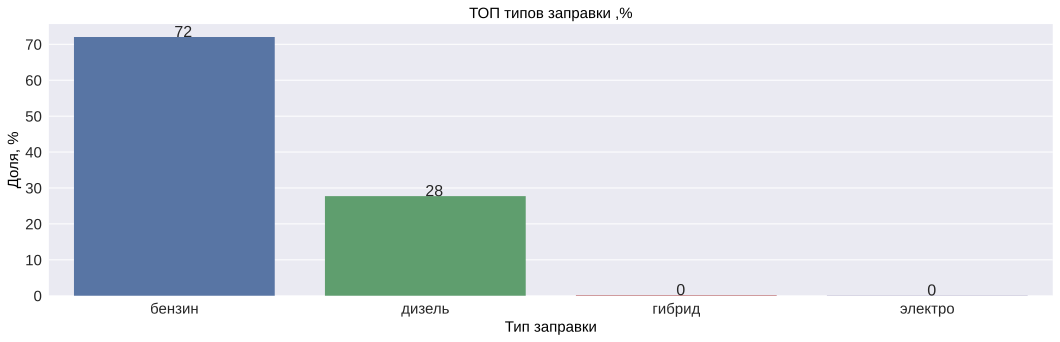

In [41]:
share(data['fuelType'],"Тип заправки", "Доля, %", 'ТОП типов заправки ,%')

In [42]:
# категориальные переменные в число
for colum in ['fuelType']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.7 Mileage

In [43]:
description_column_count(data['mileage'])

Длина столбца: 8346
Количество значений "NaN": 0
Минимальное значение: 1
Максимальное значение: 1000000


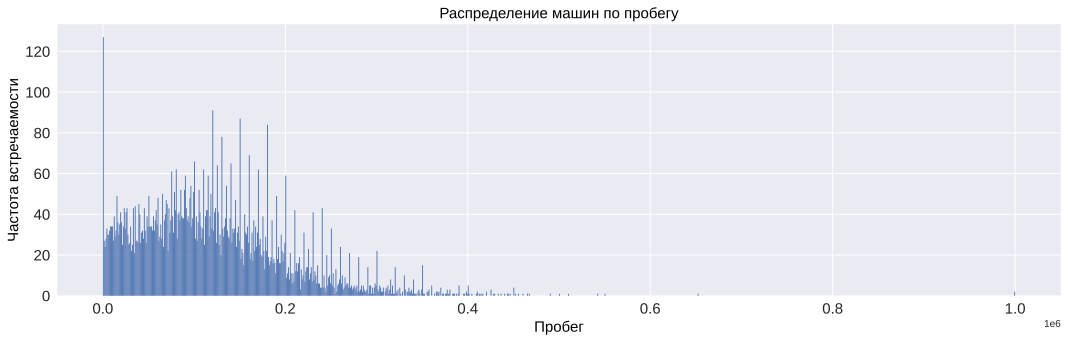

In [44]:
hist(data['mileage'], 1001000, 1000, "Частота встречаемости", "Пробег", "Распределение машин по пробегу")

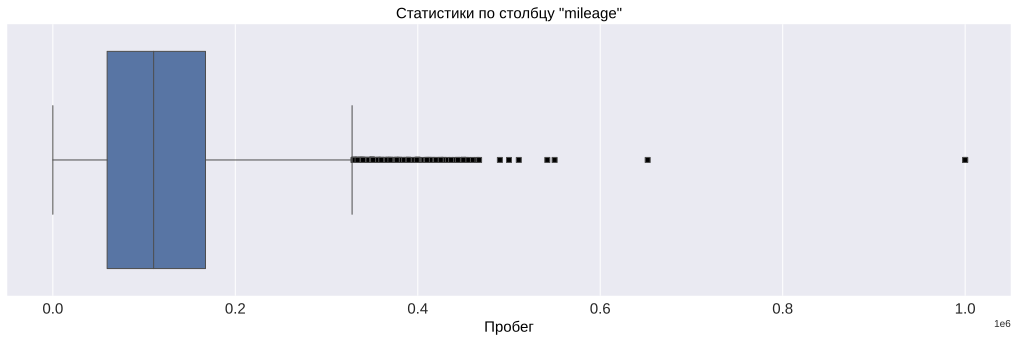

In [45]:
one_boxplot(data['mileage'], 'Статистики по столбцу "mileage"', 'Пробег')

In [46]:
outliers(data['mileage'])

25-й квартиль: 59503.75, 75-й квартиль: 167300.75, IQR: 107797.0, границы выбросов: [-102191.75,328996.25].


In [47]:
#data=data.loc[data['mileage'].between(delete_outliers(data['mileage'])[0],delete_outliers(data['mileage'])[1])]

### 7.8 ModelDate

In [48]:
description_column_count(data['modelDate'])

Длина столбца: 8346
Количество значений "NaN": 0
Минимальное значение: 1971
Максимальное значение: 2019


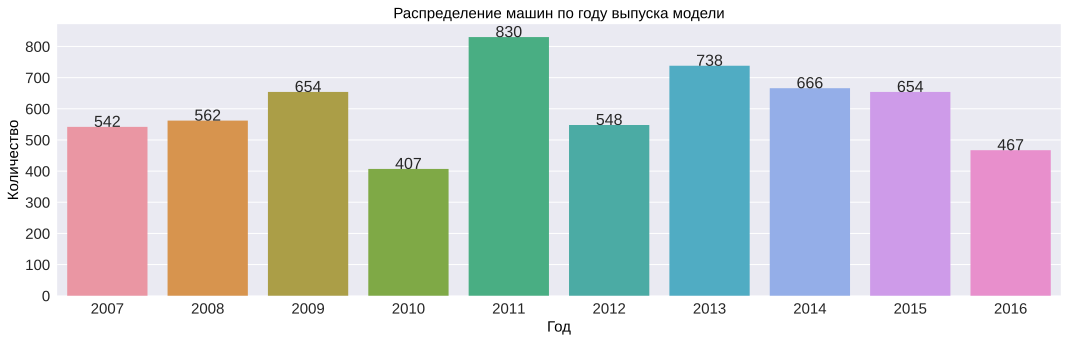

In [49]:
share_count(data['modelDate'], 'Год', 'Количество', 'Распределение машин по году выпуска модели')

In [50]:
print('Количество строк, где есть нули:', len(data[data['modelDate']==0]))

Количество строк, где есть нули: 0


### 7.9 Model_info

In [51]:
description_column(data['model_info'])

Количество уникальных значений в столбце: 122
Перечень уникальных значений: ['W124' '6ER' '3ER' '5ER' 'Q7' 'SL_KLASSE' 'A5' 'A4' 'GL_KLASSE' 'A6'
 '1ER' 'X5' 'X3' 'S_KLASSE' 'S_CLASS_MAYBACH' 'G_KLASSE' 'E_KLASSE' 'X7'
 'Q5' 'A3' 'B_KLASSE' '4' 'CLS_KLASSE_AMG' 'RS3' 'X6' 'C_KLASSE' 'X1' 'S8'
 'Q3' 'X6_M' '7ER' 'GLS_KLASSE' 'A7' 'GLC_KLASSE' 'TT' 'Q8' 'M3' 'M4'
 'C_KLASSE_AMG' 'X4' 'G_KLASSE_AMG' 'VITO' 'M_KLASSE' 'CLA_KLASSE' 'TTS'
 'GLK_KLASSE' 'SLK_KLASSE_AMG' 'CLS_KLASSE' 'R_KLASSE' 'S_KLASSE_AMG'
 'VIANO' 'GLE_KLASSE' 'S5' 'AMG_GT' 'A8' 'M_KLASSE_AMG' 'A_KLASSE' 'M5'
 'X5_M' 'GLE_KLASSE_COUPE_AMG' 'ALLROAD' 'GLE_KLASSE_COUPE' 'E_KLASSE_AMG'
 'GLA_CLASS' 'SLS_AMG' 'AMG_GLC_COUPE' 'V_KLASSE' 'GLE_KLASSE_AMG' 'X2'
 'A4_ALLROAD' 'CL_KLASSE' 'SLK_KLASSE' 'CLA_KLASSE_AMG' 'RS5' 'X_KLASSE'
 'W123' 'A1' 'S6' 'M6' 'M1' '2ER' '8ER' 'RS6' 'SL_KLASSE_AMG' 'S7' 'M2'
 'CL_KLASSE_AMG' 'Z4' 'X4_M' 'S4' 'RS4' 'I3' 'GL_KLASSE_AMG' 'Z3M'
 'SLR_KLASSE' 'CLK_KLASSE' 'Z3' 'GLC_COUPE' 'GLA_CLASS_AMG'
 '

In [52]:
print('Количество строк, где есть нули:', len(data[data['model_info']==0]))

Количество строк, где есть нули: 0


In [53]:
# категориальные переменные в число
for colum in ['model_info']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['model_info'] = data['model_info'].astype(int)

### 7.10 Name

In [54]:
description_column(data['name'])

Количество уникальных значений в столбце: 976
Перечень уникальных значений: ['300 3.0 AT (220 л.с.)' '640d xDrive 3.0d AT (313 л.с.) 4WD'
 '325xi 2.5 AT (218 л.с.) 4WD' '318i 2.0 AT (136 л.с.)'
 '520d xDrive 2.0d AT (190 л.с.) 4WD' '540i xDrive 3.0 AT (340 л.с.) 4WD'
 '3.0d AT (245 л.с.) 4WD' '350 3.5 AT (316 л.с.)' '1.8 CVT (170 л.с.)'
 '1.8 CVT (160 л.с.)' '300 3.0 AT (231 л.с.)' '320i 2.2 AT (170 л.с.)'
 '500 5.5 AT (388 л.с.) 4WD' '2.0 CVT (180 л.с.)' '650i 4.8 AT (367 л.с.)'
 '116i 1.6 AT (115 л.с.)' '320i 2.0 AT (184 л.с.)'
 '25d 3.0d AT (218 л.с.) 4WD' '20d 2.0d AT (177 л.с.) 4WD'
 '500 4.7 AT (455 л.с.) 4WD' '330i 3.0 AT (231 л.с.)' '1.8 AMT (190 л.с.)'
 '500 4x4 4.0 AT (422 л.с.) 4WD' '200 2.0 AT (184 л.с.) 4WD'
 '1.8 CVT (163 л.с.)' '320d 2.0d AT (163 л.с.)' '118i 1.5 AT (136 л.с.)'
 '30d 3.0d AT (249 л.с.) 4WD' '630i 3.0 AT (272 л.с.)'
 '2.4 CVT (177 л.с.)' '318i 1.5 AT (136 л.с.)'
 '320 3.0d AT (224 л.с.) 4WD' '2.0 AMT (249 л.с.) 4WD'
 '1.4 AMT (122 л.с.)' '200 CDI 2.1d AMT

In [55]:
print('Количество строк, где есть нули:', len(data[data['name']==0]))

Количество строк, где есть нули: 0


In [56]:
# категориальные переменные в число
for colum in ['name']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['name'] = data['name'].astype(int)

### 7.11 NumberOfDoors

In [57]:
description_column(data['numberOfDoors'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: [5 2 4 3]
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [58]:
print('Количество, где есть нули:', len(data[data['numberOfDoors']==0]))

Количество, где есть нули: 0


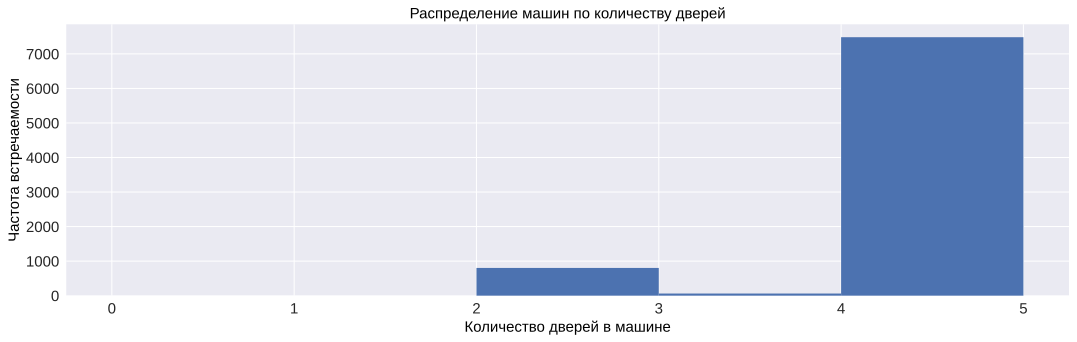

In [59]:
hist(data['numberOfDoors'], 6, 1, "Частота встречаемости", "Количество дверей в машине", 
     "Распределение машин по количеству дверей")

### 7.12 ProductionDate

In [60]:
description_column_count(data['productionDate'])

Длина столбца: 8346
Количество значений "NaN": 0
Минимальное значение: 1982
Максимальное значение: 2020


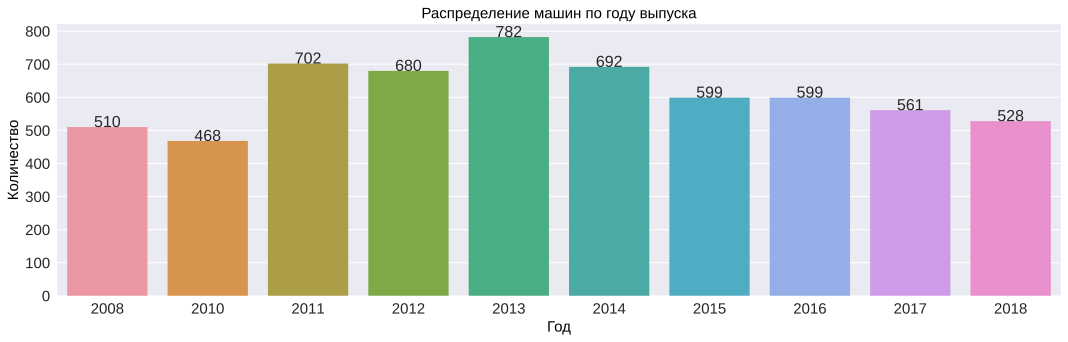

In [61]:
share_count(data['productionDate'], 'Год', 'Количество', 'Распределение машин по году выпуска')

### 7.13 VehicleConfiguration

In [62]:
description_column(data['vehicleConfiguration'])

Количество уникальных значений в столбце: 312
Перечень уникальных значений: ['WAGON_5_DOORS AUTOMATIC 3.0' 'COUPE AUTOMATIC 3.0' 'COUPE AUTOMATIC 2.5'
 'SEDAN AUTOMATIC 2.0' 'SEDAN AUTOMATIC 3.0'
 'ALLROAD_5_DOORS AUTOMATIC 3.0' 'ROADSTER AUTOMATIC 3.5'
 'LIFTBACK VARIATOR 1.8' 'SEDAN VARIATOR 1.8' 'ROADSTER AUTOMATIC 3.0'
 'SEDAN AUTOMATIC 2.2' 'ALLROAD_5_DOORS AUTOMATIC 5.5'
 'SEDAN VARIATOR 2.0' 'COUPE AUTOMATIC 4.8'
 'HATCHBACK_3_DOORS AUTOMATIC 1.6' 'ALLROAD_5_DOORS AUTOMATIC 2.0'
 'SEDAN AUTOMATIC 4.7' 'SEDAN ROBOT 1.8' 'ALLROAD_5_DOORS AUTOMATIC 4.0'
 'COUPE AUTOMATIC 4.7' 'HATCHBACK_5_DOORS AUTOMATIC 1.5'
 'SEDAN VARIATOR 2.4' 'SEDAN AUTOMATIC 1.5' 'ALLROAD_5_DOORS ROBOT 2.0'
 'SEDAN ROBOT 1.4' 'HATCHBACK_5_DOORS ROBOT 2.1' 'LIFTBACK AUTOMATIC 2.0'
 'COUPE AUTOMATIC 2.0' 'SEDAN AUTOMATIC 5.5' 'HATCHBACK_5_DOORS ROBOT 2.5'
 'SEDAN AUTOMATIC 1.6' 'SEDAN AUTOMATIC 5.2'
 'ALLROAD_5_DOORS AUTOMATIC 4.4' 'SEDAN AUTOMATIC 4.4'
 'SEDAN MECHANICAL 2.0' 'COUPE_HARDTOP AUTOMATIC 2.0' 'LIF

In [63]:
# категориальные переменные в число
for colum in ['vehicleConfiguration']:
    data[colum] = data[colum].astype('category').cat.codes

### 7.14 VehicleTransmission

In [64]:
description_column(data['vehicleTransmission'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: ['автоматическая' 'вариатор' 'роботизированная' 'механическая']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [65]:
print('Количество, где есть нули:', len(data[data['vehicleTransmission']==0]))

Количество, где есть нули: 0


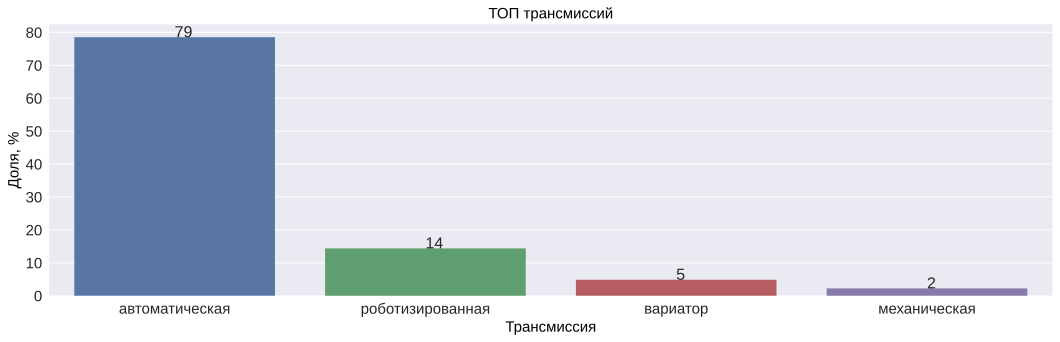

In [66]:
share(data['vehicleTransmission'], 'Трансмиссия', 'Доля, %', 'ТОП трансмиссий')

In [67]:
# категориальные переменные в число
for colum in ['vehicleTransmission']:
    data[colum] = data[colum].astype('category').cat.codes

#### 7.15 Владельцы

In [68]:
description_column(data['Владельцы'])

Количество уникальных значений в столбце: 3
Перечень уникальных значений: ['3 или более' '1\xa0владелец' '2\xa0владельца' nan]
Длина столбца: 8346
Количество значений "NaN": 1
Количество значений, встретившихся в столбце более 10 раз: 3


In [69]:
# заменим текстовые значения на числовые
# т.к. считается количество владельцев, то наличие нулей возможно (не было владельцев).
data['Владельцы'] = np.where(data['Владельцы']=='3 или более', 3,
                    np.where(data['Владельцы']=='1\xa0владелец', 1,
                    np.where(data['Владельцы']=='2\xa0владельца', 2, 0)))
data['Владельцы'] = data['Владельцы'].astype(int)

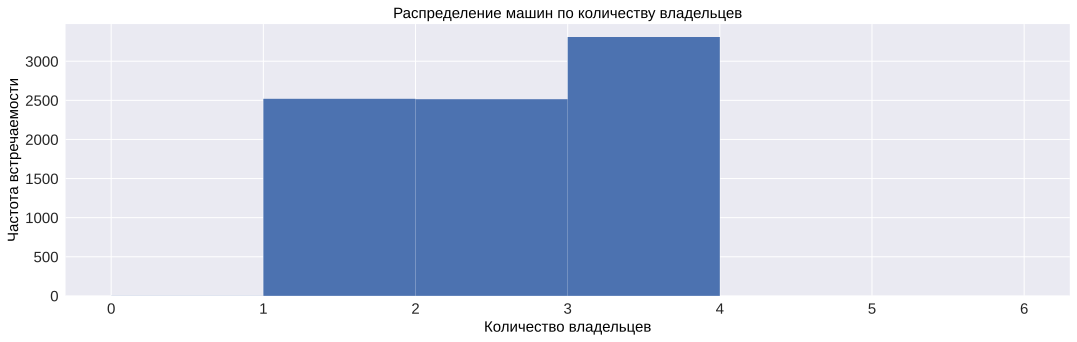

In [70]:
hist(data['Владельцы'], 7, 1, "Частота встречаемости", "Количество владельцев",
     "Распределение машин по количеству владельцев")

#### 7.16 Владение

In [71]:
description_column(data['Владение'])

Количество уникальных значений в столбце: 180
Перечень уникальных значений: ['6 лет и 3 месяца' '6 лет и 6 месяцев' nan '3 года' '2 года и 2 месяца'
 '2 года и 4 месяца' '5 лет и 4 месяца' '8 лет' '3 года и 6 месяцев'
 '2 года и 7 месяцев' '2 года и 8 месяцев' '1 год и 3 месяца'
 '1 год и 2 месяца' '6 лет и 5 месяцев' '4 года и 10 месяцев'
 '3 года и 9 месяцев' '8 месяцев' '2 года и 5 месяцев' '2 года и 3 месяца'
 '4 года и 5 месяцев' '3 года и 7 месяцев' '3 года и 3 месяца'
 '3 года и 5 месяцев' '5 лет и 1 месяц' '4 года и 1 месяц'
 '10 лет и 3 месяца' '4 года и 2 месяца' '2 года и 6 месяцев'
 '5 лет и 2 месяца' '2 месяца' '6 лет и 8 месяцев' '1 год и 1 месяц'
 '1 год и 11 месяцев' '2 года и 9 месяцев' '18 лет и 9 месяцев'
 '1 год и 8 месяцев' '5 лет и 9 месяцев' '2 года' '4 года'
 '5 лет и 5 месяцев' '7 лет и 7 месяцев' '3 года и 2 месяца' '7 лет'
 '5 лет и 8 месяцев' '8 лет и 2 месяца' '6 лет' '9 месяцев'
 '2 года и 11 месяцев' '6 лет и 1 месяц' '3 года и 8 месяцев'
 '3 года и 1 мес

In [72]:
# заменим NaN случайным признаком 
dic = []
for i in data['Владение']:
    if i == i:
        dic.append(i)
        
data['Владение'] = data['Владение'].apply(lambda x: np.random.choice(dic) if x!=x else x)

In [73]:
# категориальные переменные в число
for colum in ['Владение']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['Владение'] = data['Владение'].astype(int)

#### 7.17 ПТС

In [74]:
description_column(data['ПТС'])

Количество уникальных значений в столбце: 2
Перечень уникальных значений: ['Оригинал' 'Дубликат']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 2


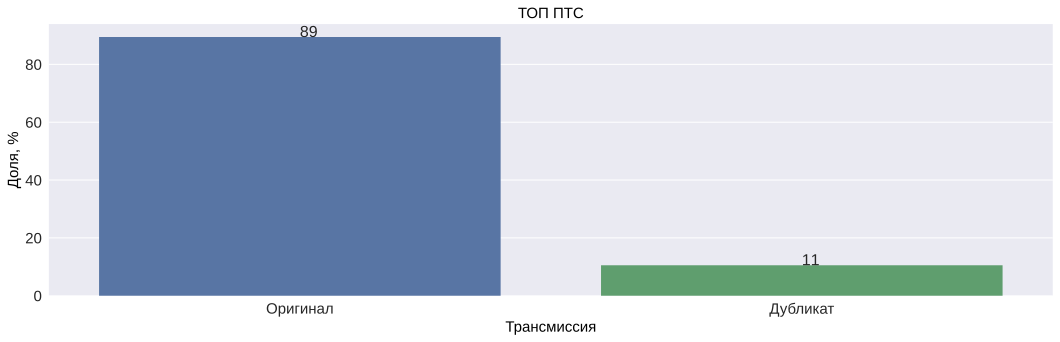

In [75]:
share(data['ПТС'], 'Трансмиссия', 'Доля, %', 'ТОП ПТС')

In [76]:
# категориальные переменные в число
for colum in ['ПТС']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['ПТС'] = data['ПТС'].astype(int)

#### 7.18 Привод

In [77]:
description_column(data['Привод'])

Количество уникальных значений в столбце: 3
Перечень уникальных значений: ['задний' 'полный' 'передний']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 3


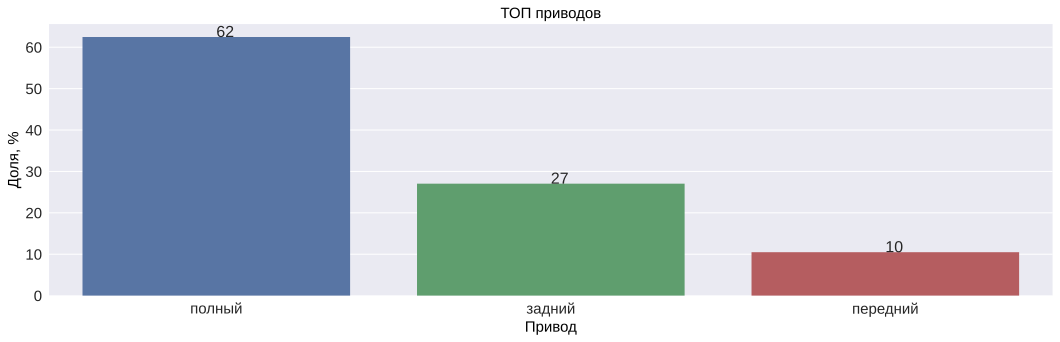

In [78]:
share(data['Привод'], 'Привод', 'Доля, %', 'ТОП приводов')

In [79]:
# категориальные переменные в число
for colum in ['Привод']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['Привод'] = data['Привод'].astype(int)

#### 7.19 Руль

In [80]:
description_column(data['Руль'])

Количество уникальных значений в столбце: 2
Перечень уникальных значений: ['Левый' 'Правый']
Длина столбца: 8346
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 1


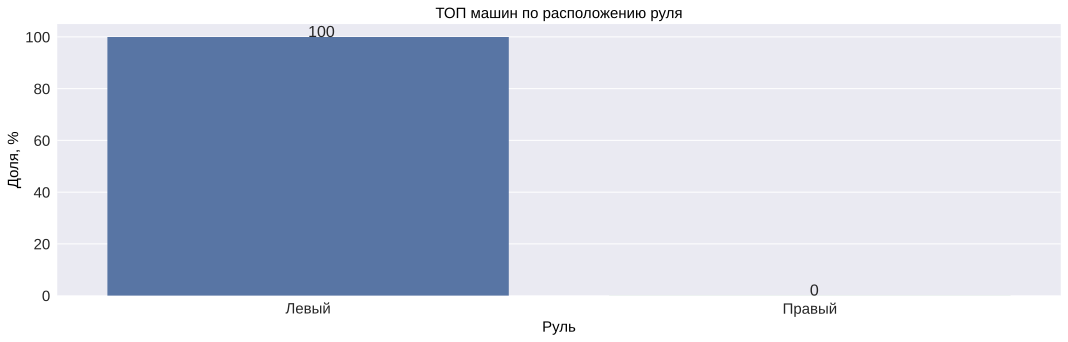

In [81]:
share(data['Руль'], 'Руль', 'Доля, %', 'ТОП машин по расположению руля')

In [82]:
# категориальные переменные в число
for colum in ['Руль']:
    data[colum] = data[colum].astype('category').cat.codes
    
data['Руль'] = data['Руль'].astype(int)

In [83]:
# модели лучше всего работают с распределением близким к нормальному, поэтому перед нормализацией возьмем логарифм 
# у числовых признаков
for column in ['mileage', 'modelDate', 'productionDate']:
    data[column] = np.log(data[column])

In [84]:
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,14,2,15,19,43,0,12.765688,7.592870,103,378,5,7.596392,291,0,3,133,1,0,0,test,0.0
1,5,1,1,19,80,2,9.615805,7.606387,8,817,2,7.607381,69,0,1,136,1,2,0,test,0.0


In [85]:
# Нормализация данных
scaler = MinMaxScaler()
for column in ['bodyType','brand', 'color','engineDisplacement','enginePower','fuelType','mileage','modelDate',
                   'model_info','name','numberOfDoors','price','productionDate','vehicleConfiguration','vehicleTransmission',
                   'Владельцы','Владение','ПТС','Привод','Руль']:
    data[column] = scaler.fit_transform(data[[column]])[:,0]

In [86]:
# итоговый dataframe с нормализированными данными
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,0.8750,1.0,1.000000,0.404255,0.281046,0.000000,0.924011,0.273218,0.851240,0.387692,1.0,0.238564,0.935691,0.0,1.000000,0.743017,1.0,0.0,0.0,test,0.0
1,0.3125,0.5,0.066667,0.404255,0.522876,0.666667,0.696015,0.834995,0.066116,0.837949,0.0,0.817211,0.221865,0.0,0.333333,0.759777,1.0,1.0,0.0,test,0.0


In [ ]:
# Просмотр матрицы корреляции без столбцов description, sel_i

plt.style.use('seaborn')
plt.figure(figsize=(16,16), dpi= 60)
sns.heatmap(data[data['price']>0].corr(), xticklabels=data[data['price']>0].corr().columns, 
            yticklabels=data[data['price']>0].corr().columns, cmap='RdYlGn', 
            center=0, annot=True, fmt='.2g')
plt.title('Корреляционная матрица', fontsize=18, color='black')
plt.xticks(fontsize=15, color='black')
plt.yticks(fontsize=15, color='black')
plt.tick_params(axis='both', labelsize=15)
plt.show()

#### 8. ML модель CatBoost

**Комментарий:** в dataframe есть столбцы с сильной мультиколлинеарностью:
* bodyType коррелирует с vehicleConfiguration - 0.92%
* engineDisplacement коррелирует с enginePower - 0.87%
* mileage коррелирует с modelDate - 0.65%
* mileage коррелирует с productionDate - 0.69%
* modelDate коррелирует с productionDate - 0.96%
* name коррелирует с enginePower, engineDisplacemen - 0.66%

Уберем из анализа столбцы name, modelDate, engineDisplacement, vehicleConfiguration, т.к. между ними сильная мультиколлинеарность.


In [ ]:
data=data[['bodyType','brand', 'color','enginePower','fuelType','mileage','model_info',
           'numberOfDoors','price','vehicleTransmission', 'productionDate',
           'Владельцы','Владение','ПТС','Привод','Руль','sample']]

In [ ]:
# Выделим тестовую часть
train_data = data.query('sample == "train"').drop(['sample'], axis=1)
test_data = data.query('sample == "test"').drop(['sample'], axis=1)

y = train_data.price.values
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

In [ ]:
# выделим под тест 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# используем модель CatBoost, которая хорошо работает с категориальными признаками
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         )

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

In [ ]:
sub_predict_catboost = model.predict(X_sub)

**Вывод:** после обработки dataset (устранения выбросов и мультиколлинеарности, замены категориальных признаков на числовые) результат улучшился до 13,85%.

#### 9. Простая нейронная сеть на основе градиентного бустинга

In [ ]:
X_train.head()

In [ ]:
# добавим BatchNormalization и Dropout
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [ ]:
# компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
# сохраняем чекпойнты и настраиваем EarlyStopping
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [100]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,)

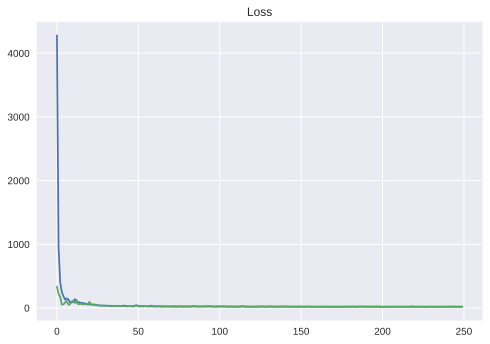

In [101]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [102]:
#model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [103]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 16.21%


In [104]:
sub_predict_nn1 = model.predict(X_sub)

**Вывод:** простая нейронная сеть показала 14,46%.

#### 10. Multi-Input сеть: табличные данные + текст

**Комментарий**: добавим в нейронную сеть текстовый данные из столбца description. Так как dataframe data не содержится столбец discription, возьмем его из первичных данных, выполнив предобработку.

In [105]:
train_1 = pd.read_csv(DATA_DIR + 'train.csv')
test_1 = pd.read_csv(DATA_DIR + 'test.csv')
data_1 = test_1.append(train_1, sort=False).reset_index(drop=True)
print(train_1.shape, test_1.shape, data_1.shape)

# удалим дубликаты
data_1 = data_1.drop_duplicates()

(6682, 22) (1671, 21) (8353, 22)


In [106]:
data_1['description']

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [107]:
# заменим символы в столбце пустыми значениями
simbol_list = ['•','—','«','»','▼','–','∙', '。','☑','✔','➥','●','®','☛','₽','\r','№','\n','г.',
               'ооо','мб','тд','гк','r19','тыс','🤛']
for x in simbol_list:
    data_1['description'] = data_1['description'].apply(lambda i : '' if x in i else i)


In [108]:
# проведем лемматизацию текста
nlp = Russian()
new_description = []
for sentence in data_1['description']:
    doc = nlp(sentence)
    # берем только текст, не берем стоп-слова
    lemmatized_output = " ".join([token.lemma_ for token in doc if not token.is_stop])
    new_description.append(lemmatized_output)

In [109]:
# токениризация столбца description
# максимальное количество слов
MAX_WORDS = 100000
# максимальное количество слов в каждом описании
MAX_SEQUENCE_LENGTH = 256

In [110]:
new_description = pd.DataFrame(new_description)
new_description.columns = (['description'])
new_description['description'].head(5)

0                                                     
1                                                     
2                                                     
3    Автомобиль отличном состояние , родной краске ...
4                                                     
Name: description, dtype: object

In [111]:
# split данных
text_train = new_description['description'].iloc[X_train.index]
text_test = new_description['description'].iloc[X_test.index]
text_sub = new_description['description'].iloc[X_sub.index]

In [112]:
text_train.head()

3094                                                     
6011    Автомобиль поддерживать   очень хорошем состоя...
6038     Автомобиль отличном состояние . Торг возможный .
7226    Автомобиль идеальном состояние , гарантии , ст...
2042                                                     
Name: description, dtype: object

In [113]:
# создаём словарь — в Keras 
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(new_description['description'])

In [114]:
tokenize.word_index

{'состояние': 1,
 'автомобиль': 2,
 'салон': 3,
 'машина': 4,
 '2': 5,
 'авто': 6,
 'комплект': 7,
 'торг': 8,
 'без': 9,
 'пробег': 10,
 'отличном': 11,
 '1': 12,
 'дтп': 13,
 '3': 14,
 'комплектация': 15,
 'птс': 16,
 'продавать': 17,
 'дилера': 18,
 'телефон': 19,
 'хорошем': 20,
 'комфорт': 21,
 'кузов': 22,
 'два': 23,
 'новый': 24,
 'вложение': 25,
 'обзор': 26,
 'работать': 27,
 'резина': 28,
 'купить': 29,
 'безопасность': 30,
 'обслуживание': 31,
 'года': 32,
 'мультимедиа': 33,
 'диск': 34,
 'защита': 35,
 'угон': 36,
 'идеальном': 37,
 'очень': 38,
 'двигатель': 39,
 '4': 40,
 'владелец': 41,
 'км': 42,
 'требовать': 43,
 'оригинал': 44,
 'вопросы': 45,
 'капот': 46,
 'полностью': 47,
 'обмен': 48,
 '5': 49,
 'проверки': 50,
 'любые': 51,
 '6': 52,
 'ключ': 53,
 'резины': 54,
 'беспокоить': 55,
 'ездить': 56,
 'родной': 57,
 'сделать': 58,
 'официального': 59,
 'полный': 60,
 'замена': 61,
 'масло': 62,
 'участвовать': 63,
 '7': 64,
 'пройти': 65,
 'своевременное': 66,
 'дис

In [115]:
# произведем векторизацию текста
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5675, 256) (1002, 256) (1669, 256)


In [116]:
print(text_train.iloc[6])
print(text_train_sequences[6])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [117]:
# Теперь строим сеть для обработки текста. Для простоты в примере используем LSTM:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(BatchNormalization())
model_nlp.add(L.Dropout(0.25))

In [118]:
# добавим ещё одну сеть — созданную для табличных данных
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(BatchNormalization())
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(BatchNormalization())
model_mlp.add(L.Dropout(0.25))

In [119]:
# Объединим 2 сети в Multi-Input сеть, то есть сеть, которая позволяет брать на вход несколько сетей и объединять их результаты. 
# За объединение отвечает слой L.concatenate:

combinedInput = L.concatenate([model_nlp.output, model_mlp.output])

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [120]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     1869056     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dense_4_input (InputLayer)      [(None, 15)]         0                                            
_______________________________________________________________________________________

In [121]:
# Готовимся к обучению: настраиваем показатели, чекпойнты, EarlyStopping:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [122]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [123]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 3s 266ms/step - loss: 2525.9402 - MAPE: 2525.9402 - val_loss: 211.0454 - val_MAPE: 211.0454
Epoch 2/500
12/12 [==============================] - 2s 205ms/step - loss: 630.5149 - MAPE: 630.5149 - val_loss: 458.3449 - val_MAPE: 458.3449
Epoch 3/500
12/12 [==============================] - 3s 211ms/step - loss: 251.3584 - MAPE: 251.3584 - val_loss: 97.9278 - val_MAPE: 97.9278
Epoch 4/500
12/12 [==============================] - 2s 206ms/step - loss: 135.7410 - MAPE: 135.7410 - val_loss: 54.9381 - val_MAPE: 54.9381
Epoch 5/500
12/12 [==============================] - 2s 207ms/step - loss: 96.9985 - MAPE: 96.9985 - val_loss: 44.6084 - val_MAPE: 44.6084
Epoch 6/500
12/12 [==============================] - 2s 204ms/step - loss: 124.2758 - MAPE: 124.2758 - val_loss: 47.1887 - val_MAPE: 47.1887
Epoch 7/500
12/12 [==============================] - 3s 215ms/step - loss: 97.6340 - MAPE: 97.6340 - val_loss: 47.7285 - val_MAPE: 47.7285
Epoch 8/500

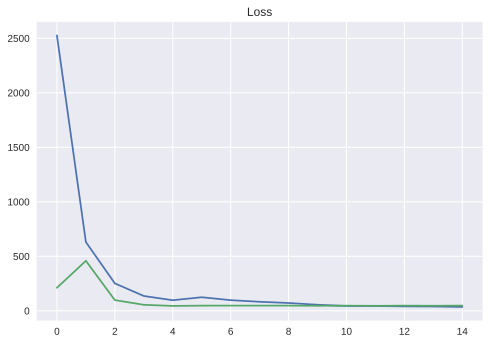

In [124]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [125]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 44.61%


**Вывод:** простая нейронная сеть + текст дает результат в 15,83%.

#### 11. Multi-Input сеть: табличные данные + текст + изображения

In [126]:
# мы удаляли колонку sell_id ранее, поэтому загрузим данные снова и выполним предобработку
train_2 = pd.read_csv(DATA_DIR + 'train.csv')
test_2 = pd.read_csv(DATA_DIR + 'test.csv')
test_2['price'] = 0 

data_2 = test_2.append(train_2, sort=False).reset_index(drop=True)
print(train_2.shape, test_2.shape, data_2.shape)

# удалим дубликаты
data_2 = data_2.drop_duplicates()

(6682, 22) (1671, 22) (8353, 22)


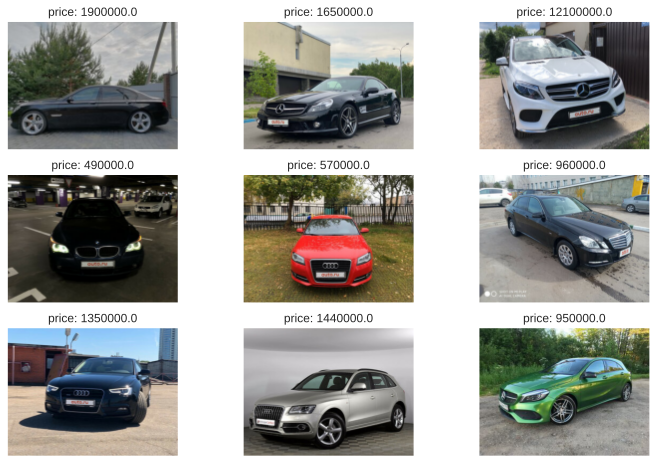

In [127]:
# убедимся, что цены и фото подгрузились корректно
plt.figure(figsize = (12,8))

random_image = train_2.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [128]:
# подгрузим эти картинки в память и создадим матрицу
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data_2['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5675, 240, 320, 3) dtype uint8
images shape (1002, 240, 320, 3) dtype uint8
images shape (1669, 240, 320, 3) dtype uint8


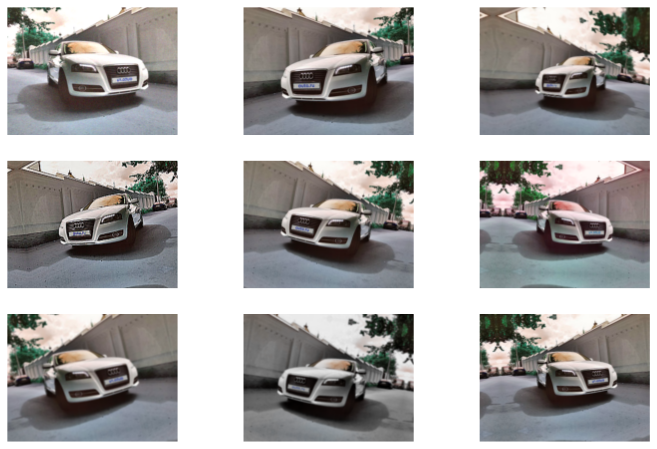

In [129]:
# сделаем аугментацию картинок
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [130]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [131]:
# используем токенизатор
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(new_description['description'])

In [132]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, new_description['description'].iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, new_description['description'].iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, new_description['description'].iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [133]:
# Переходим к построению сверточной сети для анализа изображений
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, 
                                                                       input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [134]:
# сеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.BatchNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.BatchNormalization(),
    L.Dropout(0.5),
    ])

In [135]:
# сеть NLP для текстовой предобработки
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    L.BatchNormalization(),
    L.Dropout(0.25)
    ])

In [136]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# добавляем голову
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [137]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [138]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [139]:
history = model.fit(train_dataset.batch(30),
                    epochs=30, #100
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/30
190/190 [==============================] - 124s 653ms/step - loss: 307.7388 - MAPE: 307.7388 - val_loss: 45.1155 - val_MAPE: 45.1155
Epoch 2/30
190/190 [==============================] - 122s 642ms/step - loss: 37.3810 - MAPE: 37.3810 - val_loss: 29.1101 - val_MAPE: 29.1101
Epoch 3/30
190/190 [==============================] - 120s 631ms/step - loss: 37.1152 - MAPE: 37.1152 - val_loss: 67.8350 - val_MAPE: 67.8350
Epoch 4/30
190/190 [==============================] - 119s 628ms/step - loss: 34.2977 - MAPE: 34.2977 - val_loss: 26.0256 - val_MAPE: 26.0256
Epoch 5/30
190/190 [==============================] - 119s 628ms/step - loss: 33.8526 - MAPE: 33.8526 - val_loss: 26.5279 - val_MAPE: 26.5279
Epoch 6/30
190/190 [==============================] - 120s 633ms/step - loss: 31.9991 - MAPE: 31.9991 - val_loss: 24.1734 - val_MAPE: 24.1734
Epoch 7/30
190/190 [==============================] - 119s 626ms/step - loss: 32.4327 - MAPE: 32.4327 - val_loss: 36.1249 - val_MAPE: 36.1249
Epoc

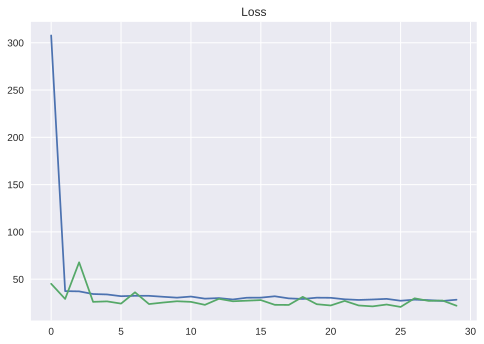

In [140]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [141]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 21.94%


**Вывод:** простая нейронная сеть + текст + изображение дает результат в 21,94%.

#### 12. Ансамблируем ML- и DL-сети

In [142]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 15.89%


**Вывод:** ансамблирование сети улучшает результат до 15,84%.

#### 13. Бонус: проброс признака

In [143]:
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)

In [144]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output, L.Flatten()(emb_productiondate),])
# добавление головы
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input, productiondate], outputs=head)

In [145]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     1869056     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dense_4_input (InputLayer)      [(None, 15)]         0                                            
_______________________________________________________________________________________

In [146]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [147]:
history = model.fit([text_train_sequences, X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 3s 276ms/step - loss: 2754.3816 - MAPE: 2754.3816 - val_loss: 92.5094 - val_MAPE: 92.5094
Epoch 2/500
12/12 [==============================] - 2s 207ms/step - loss: 238.0232 - MAPE: 238.0232 - val_loss: 53.7456 - val_MAPE: 53.7456
Epoch 3/500
12/12 [==============================] - 3s 214ms/step - loss: 91.4358 - MAPE: 91.4358 - val_loss: 54.2787 - val_MAPE: 54.2787
Epoch 4/500
12/12 [==============================] - 2s 206ms/step - loss: 67.2348 - MAPE: 67.2348 - val_loss: 50.6857 - val_MAPE: 50.6857
Epoch 5/500
12/12 [==============================] - 3s 220ms/step - loss: 50.8306 - MAPE: 50.8306 - val_loss: 46.0776 - val_MAPE: 46.0776
Epoch 6/500
12/12 [==============================] - 2s 205ms/step - loss: 43.9654 - MAPE: 43.9654 - val_loss: 44.7640 - val_MAPE: 44.7640
Epoch 7/500
12/12 [==============================] - 3s 215ms/step - loss: 41.5869 - MAPE: 41.5869 - val_loss: 48.8484 - val_MAPE: 48.8484
Epoch 8/500
12/12 [==

In [148]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([text_test_sequences, X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 19.61%


**Вывод:** проброс признака улучшает результат до 19,61%